# Architectual reconstruction tools

## Data gathering

In [1]:
# change to point to the right folder on your mahchine where you cloned the Zeeguu-Core
CODE_ROOT_FOLDER = '/Users/egh/Zeeguu-Core/zeeguu_core'

# And a helper function to construct
# the full path of a file by adding the CODE_ROOT_FOLDER

def full_path(file_name):
    return CODE_ROOT_FOLDER+file_name

In [2]:
import sys
import pathlib
from pathlib import Path
import re
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
def LOC(file):
    return sum([1 for line in open(file)])

### List files, sorted by lines of code

In [4]:
files_and_LOCs = []
for file in Path(CODE_ROOT_FOLDER).rglob("*.py"):
    files_and_LOCs.append(
        (LOC(str(file)),
         str(file)
        )
    )

files_and_LOCs.sort(key = lambda x: -x[0])
for each in files_and_LOCs:
    print (str(each[0]) + " " + str(each [1]))

575 /Users/egh/Zeeguu-Core/zeeguu_core/model/user.py
475 /Users/egh/Zeeguu-Core/zeeguu_core/word_scheduling/arts/tools/algo_parameter_approximator.py
403 /Users/egh/Zeeguu-Core/zeeguu_core/model/user_reading_session.py
341 /Users/egh/Zeeguu-Core/zeeguu_core/content_recommender/mixed_recommender.py
328 /Users/egh/Zeeguu-Core/zeeguu_core/model/bookmark.py
287 /Users/egh/Zeeguu-Core/zeeguu_core/language/strategies/word_history_difficulty_estimator.py
280 /Users/egh/Zeeguu-Core/zeeguu_core/model/word_knowledge/word_interaction_history.py
274 /Users/egh/Zeeguu-Core/zeeguu_core/model/article.py
257 /Users/egh/Zeeguu-Core/zeeguu_core/model/user_activitiy_data.py
238 /Users/egh/Zeeguu-Core/zeeguu_core/model/user_exercise_session.py
228 /Users/egh/Zeeguu-Core/zeeguu_core/content_retriever/article_downloader.py
226 /Users/egh/Zeeguu-Core/zeeguu_core/model/feed.py
205 /Users/egh/Zeeguu-Core/zeeguu_core/model/user_article.py
202 /Users/egh/Zeeguu-Core/zeeguu_core/language/strategies/cognacy_wh_dif

### Draw dependency graph from imports

In [29]:
# find loc in each folder
import os

directory_contents = os.listdir(CODE_ROOT_FOLDER);

dirs_and_LOCs = []

for dir in directory_contents:
    inc = 0;
    for file in Path(CODE_ROOT_FOLDER + "/" + dir).rglob("*.py"):
        inc += LOC(str(file))

    dirs_and_LOCs.append(
        ((inc), str(dir)))

dirs_and_LOCs.sort(key = lambda x: -x[0])
for each in dirs_and_LOCs:
    print (str(each[0]) + " " + str(each [1]))

5582 model
1097 language
985 word_scheduling
341 content_recommender
311 content_retriever
192 util
161 bookmark_quality
87 emailer
65 configuration
20 definition_of_learned
0 constants.py
0 __init__.py
0 __pycache__


In [35]:
def extract_import_from_line(line):
    # TODO: think about how to detect imports when
    # they are inside a function / method
    x = re.search("^import zeeguu_core.(\S+)", line) 
    x = re.search("^from zeeguu_core import (\S+)", line)
    return x.group(1)

In [36]:
def imports(file):
    # extracts all the imported modules from a file
    lines = [line for line in open(file)]
    
    all_imports = []
    for line in lines:
        try:
            all_imports.append(extract_import_from_line(line))
        except:
            continue

    return all_imports

#assert "sqlalchemy" in imports(full_path('zeeguu_core/model/user.py'))

In [37]:
def module_from_file_path(folder_prefix, full_path):
    # extracting a module from a file name
    # e.g. /Users/mircea/Zeeguu-Core/zeeguu_core/model/user.py -> zeeguu_core.model.user
    
    file_name = full_path[len(folder_prefix):]
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

def module(full_path):
    return module_from_file_path(CODE_ROOT_FOLDER, full_path)

assert 'zeeguu_core.model.user' == module(full_path('zeeguu_core/model/user.py'))

In [38]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")

    G = nx.Graph()

    for file in files:
        m = module(str(file))
        if m not in G.nodes:
            G.add_node(m)

        for each in imports(str(file)):
            G.add_edge(m, each)

    return G

In [39]:
def draw_graph(G):
    plt.figure(figsize=(10,6))
    nx.draw(G)
    plt.show()

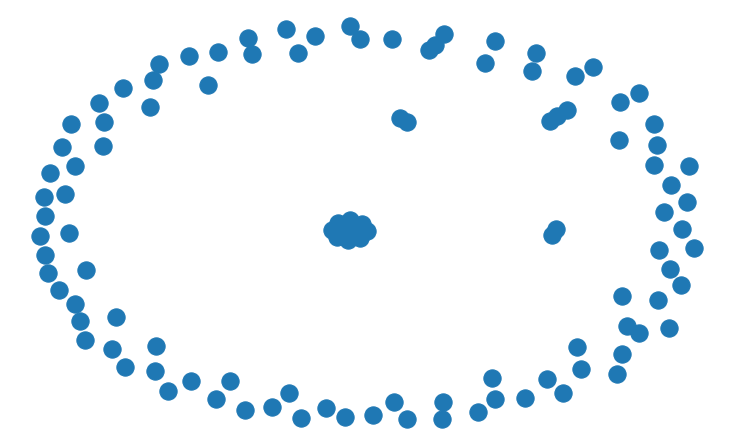

In [40]:
G = dependencies_graph()
draw_graph(G)

## Basic Abstraction

### Aggregating Dependencies


In [41]:
def top_level_module(module_name, depth=1):
    # extracts the parent of depth X 
    # e.g. top_level_module(zeeguu_core.model.util, 1) -> zeeguu_core
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_module("zeeguu_core.model.util") == "zeeguu_core")
assert (top_level_module("zeeguu_core.model.util", 2) == "zeeguu_core.model")

In [42]:
def abstracted_to_top_level(G):
    aG = nx.Graph()
    for each in G.edges():
        aG.add_edge(top_level_module(each[0]),
                    top_level_module(each[1]))
    return aG

In [43]:
def draw_graph_with_labels(G, figsize=(20,20)):
    plt.figure(figsize=figsize)
    nx.draw(G,with_labels=True, font_size=40)
    plt.show()

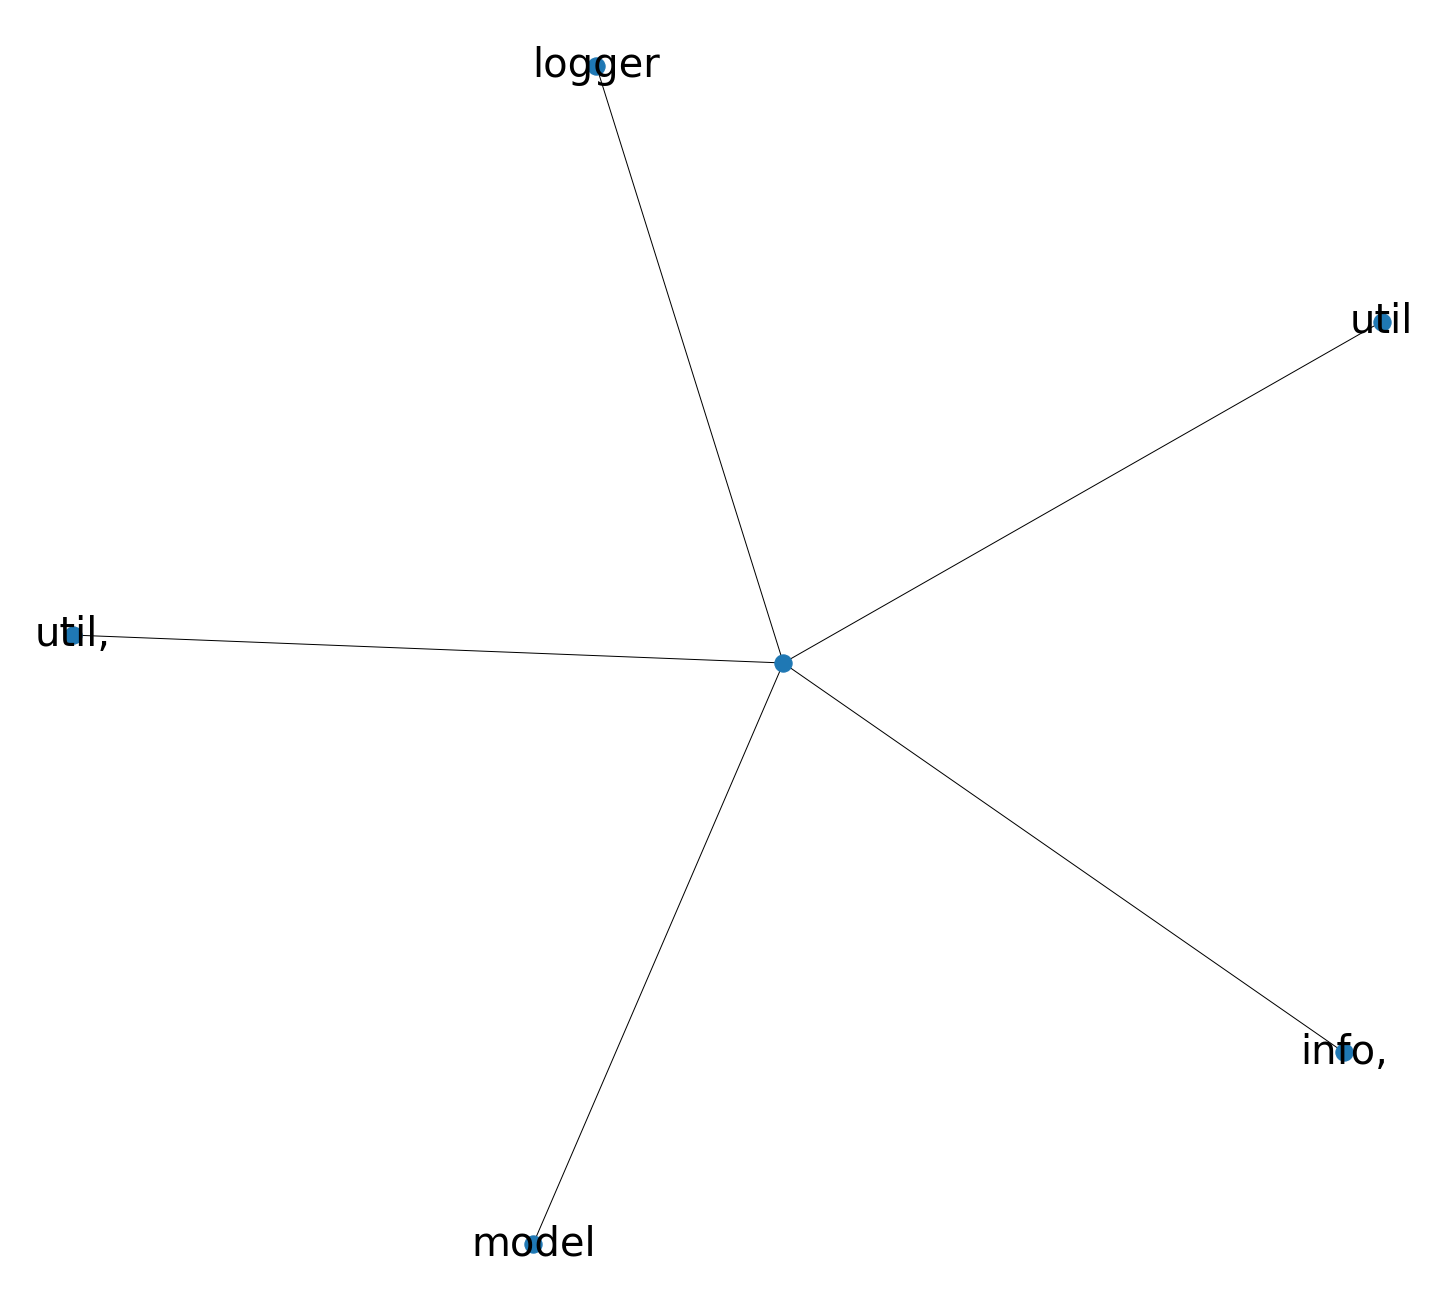

In [44]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
draw_graph_with_labels(aG, (20,18))

## Distinguishing System Modules 

In [45]:

def system_module(m):
    return m.startswith('zeeguu')

In [46]:
def abstracted_to_top_level(G):
    aG = nx.Graph()
    for each in G.edges():
        source = top_level_module(each[0])
        destination = top_level_module(each[1])
        if system_module(source) and system_module(destination):
            aG.add_edge(source, destination)
    return aG

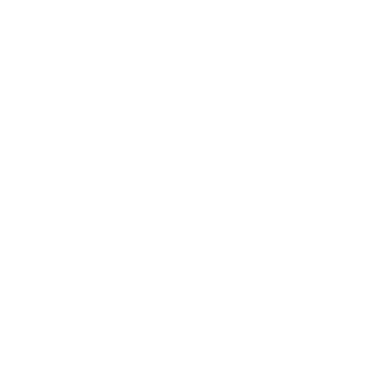

In [47]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
draw_graph_with_labels(aG, (5,5))

## But Dependencies Have Directions...



In [19]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        m = module(str(file))
        if m not in G.nodes:
            G.add_node(m)

        for each in imports(str(file)):
            G.add_edge(m, each)

    return G

In [20]:
def abstracted_to_top_level(G):
    aG = nx.DiGraph()
    for each in G.edges():
        source = top_level_module(each[0])
        destination = top_level_module(each[1])
        if system_module(source) and system_module(destination):
            aG.add_edge(source, destination)
    return aG

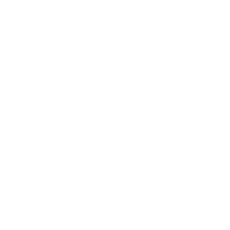

In [21]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_labels(directedAbstracted, (3,3))

### Oooops. Something unexpected ... 
Core **should not** depend on API


## Mapping other modules that we know are part of the system... e.g. tools

In [22]:
def system_module(m):
    return m.startswith('zeeguu') or m=='tools' or m=='playground'

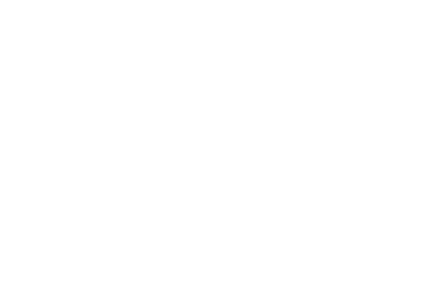

In [23]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_labels(directedAbstracted, (6,4))

# 2. Basic Presentation

### Remember the Definition of Architecture
- includes properties of modules


In [32]:
def module_size(m):
    size = 0
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    for file in files:
        module_name = module(str(file))
        if module_name.startswith(m + '.'):
            size += LOC(str(file))
            
    return size

module_size("zeeguu_core")
module_size("zeeguu_core_test")
module_size("zeeguu_api")

0

In [33]:
def draw_graph_with_weights(G, weight_function, figsize=(10,10)):
    
    node_weights = [weight_function(each) for each in G.nodes]
    
    plt.figure(figsize=figsize)
    nx.draw(G,
            with_labels=True,
            node_size=node_weights)
    plt.show()

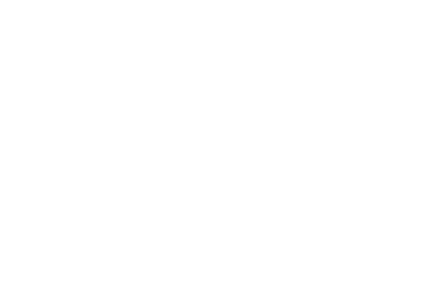

In [34]:
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_weights(directedAbstracted, module_size, (6,4))

## What did we learn? 

  - external dependencies (3rd party modules) can be filtered to remove noise
  - directed dependencies provide extra information
  - filtering system modules 
  - mapping metrics when visualizing increases the expressivity of the views
  - module views allow the detection of misdirected dependencies




## Importance of Dependencies


To tell *the story of this view* we need nouns and verbs:
  - nouns are the nodes
  - verbs are the dependencies
    - what is the meaning of each 
    - how "strong" is it


## Discussion & Lessons Learned
- Semi-automatic solutions are most of the times required
  - full automation with clustering
     - has been tried with 
       - coupling cohesion
       - natural language analysis
  - even in the case of clustering we still need human intervention
  

- The difference between this and a hand-drawn UML diagram? 
  - what we created today is always telling the truth
  - but, maybe not *all* the truth? 
  - and not *always* the truth?
    



## For your projects
- draw the architecture of the zeeguu_core itself!
  - this is where most of the functionality seems to be found
  - all the other modules depend on it
  

- can you explain the dependencies?


- consider exporting the data into specialized graph visualization tools 
  - networkx [has support for this ](https://networkx.github.io/documentation/stable/reference/drawing.html)


